# Tutorial Notebook for nisarhdf.nisarGOFFHDF
---

This notebook demonstrates the functionality of `nisarGOFFHDF`, which is at tool for reading NISAR **GOFF** products.  Some of its functionality is specifically developed for the Greenland Mapping Project (GrIMP) workflows, but it may also be of general use for working with these products. If nothing else, the source code provides examples of how to unpack these projects.

## Installation

The easiest way to ensure the code works is to create a custom environment using the *environment.yml* file included in this *nisarhdf* repository. To do so execute the following,

`conda env create -f environment.yml`

Then setup the kernel for the Jupyter notebooks with the command:

`python -m ipykernel install --user --name=nisarcryo`

Then activate the environment:

`conda activate nisarcryo`

Finally, start Jupyter and open the notebooks.

**Even if you want to work with your existing environment, the *environment.yml* file demonstrates which packages must be installed if they are not already present.**


## Python Imports

In [1]:
%load_ext autoreload
%autoreload 2
import nisarhdf
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
from osgeo import gdal

In [2]:
def autoScaleRange(myVar, percentile):
        '''
        If percentile less than 100, will select vmin as (100-percentile)
        and vmax as percentile of myVar, unless they fall out of the vmin and
        vmax bounds.
        Parameters
        ----------
        myVar : nparray
            Data being displayed.
        vmin : float
            Absolute minimum value.
        vmax : TYPE
            absolute maximum value.
        percentile : TYPE
            Clip data at (100-percentile) and percentile.

        Returns
        -------
        vmin, vmax - updated values based on percentiles.
        '''
        vmax = np.percentile(myVar[np.isfinite(myVar)], percentile)
        vmin = np.percentile(myVar[np.isfinite(myVar)], 100 - percentile)
        return vmin, vmax

In [3]:
def createDivider(ax, colorBarPosition='right', colorBarSize='5%',
                   colorBarPad=0.05):
    '''
    Create divider for color bar
    '''
    divider = make_axes_locatable(ax)  # Create space for colorbar
    return divider.append_axes(colorBarPosition, size=colorBarSize,
                               pad=colorBarPad)

def colorBar(pos, ax, colorBarLabel, colorBarPosition, colorBarSize,
              colorBarPad, labelFontSize, plotFontSize, extend='max',
              fontScale=1):
    '''
    Color bar for image
    '''
    # Create an divided axis for cb
    cbAx = createDivider(ax, colorBarPosition=colorBarPosition,
                             colorBarSize=colorBarSize,
                               colorBarPad=colorBarPad)
    # Select orientation
    orientation = {'right': 'vertical', 'left': 'vertical',
                   'top': 'horizontal',
                   'bottom': 'horizontal'}[colorBarPosition]

    cb = plt.colorbar(pos, cax=cbAx, orientation=orientation,
                      extend=extend)
    cb.set_label(colorBarLabel, size=labelFontSize * fontScale)
    cb.ax.tick_params(labelsize=plotFontSize * fontScale)
    if colorBarPosition in ['right', 'left']:
        cbAx.yaxis.set_ticks_position(colorBarPosition)
        cbAx.yaxis.set_label_position(colorBarPosition)
    elif colorBarPosition in ['top', 'tottom']:
        cbAx.xaxis.set_ticks_position(colorBarPosition)
        cbAx.xaxis.set_label_position(colorBarPosition)

## Open the HDF

Edit the path below to point to the GOFF product you wish to work with.

In [4]:
GOFFFile = '/Volumes/insar1/ian/NISAR/ALOS2-TestPhase/track-1/49672_5280/GOFF_ALOS2496725280-230804_ALOS2498795280-230818.h5'

Create an instance and open the hdf as shown below. For normal products, you shouldn't have to specify the orbit, but while the orbit fields are present in the example file, they are not populated. When you open the hdf, you can specify the precise orbit XMLs if desired, which are release a few weeks after the MOI orbits used in the processing.

In [5]:
myGOFF = nisarhdf.nisarGOFFHDF()
myGOFF.openHDF(GOFFFile , referenceOrbitXML=None, secondaryOrbitXML=None,
               referenceOrbit=49672, secondaryOrbit=49879, frame=5280)

GOFF referenceZeroDopplerStartTime


## GOFF Parameters

A summary of some of the more important parameters for the **GOFF** products can be obtained by.

In [6]:
myGOFF.printParams()

GOFF.referenceOrbit = 49672 
GOFF.frame = 5280 
GOFF.datetime = 2023-08-04 14:57:47.166045 
GOFF.referenceGranule = rslc_ALOS2496725280-230804.h5 
GOFF.SLCNearRange = 814637.0 
GOFF.SLCFarRange = 852284.282920905 
GOFF.SLCFirstZeroDopplerTime = 53867.166045 
GOFF.SLCLastZeroDopplerTime = 53877.165933569675 
GOFF.secondaryOrbit = 49879 
GOFF.secondaryDatetime = 2023-08-18 14:57:47.171967 
GOFF.secondaryGranule = rslc_ALOS2498795280-230818.h5 
GOFF.LookDirection = right 
GOFF.PassType = descending 
GOFF.Wavelength = 0.23840349999999996 
GOFF.PRF = 3051.234 
GOFF.epsg = 3031 
GOFF.xSize = 1211 
GOFF.ySize = 1210 
GOFF.dx = 80.0 
GOFF.dy = -80.0 

Data Fields
GOFF.slantRangeOffset
GOFF.slantRangeOffsetVariance
GOFF.alongTrackOffset
GOFF.alongTrackOffsetVariance
GOFF.crossOffsetVariance
GOFF.correlationSurfacePeak
GOFF.snr


In [7]:
myGOFF.yCoords

array([-420436.41634154, -420516.41634154, -420596.41634154, ...,
       -516996.41634154, -517076.41634154, -517156.41634154])

## Display Data

In [8]:
fields = myGOFF.dataFields
cbarExtend = ['both', 'max', 'both', 'max', 'max', 'max', 'max']

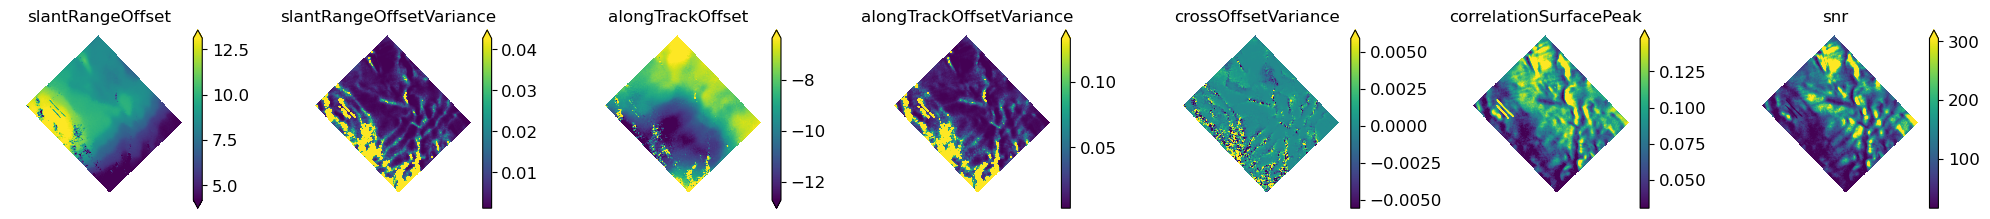

In [9]:
fig, axes = plt.subplots(1, 7, figsize=(20, 5))
layer = 3
for field, ax, cbE in zip(fields, axes, cbarExtend):
    # Extract the data for each field
    data = np.squeeze(getattr(myGOFF, field)[layer-1])
    # threshold at top and bottom 5%
    vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax)
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend=cbE)
    ax.set_title(field)
    ax.axis('off')
fig.tight_layout()

## Remove outliers

Outliers can be remove by thresholding on the various fields. Note only outliers for the offsets are removed (all statistics are retained). For example to threshold by `correlationSurfacePeak` for all layers with layter dependent thresholds:

In [10]:
myGOFF.removeOutlierOffsets('correlationSurfacePeak', thresholds=[0.07, 0.06, 0.025], layers=[1, 2, 3])

In this example, we could have used `snr` instead of `correlationPeak`. As the figure above indicates, these two metrics are similar in characters. As a result, empirically determining the appropriate threshold is more important than which metric is actually used. Note these changes are only applied to the actual offsets.

With the projected coordinates, the plots follow the convention in which the data are stored in the HDF with the origin as the upper-left corner (first line), so `imshow` is called with `origin='upper'` (the default). As a result, the extent must be set for upper-left corner, which is set as `extent=myRUNW.extentUL`.

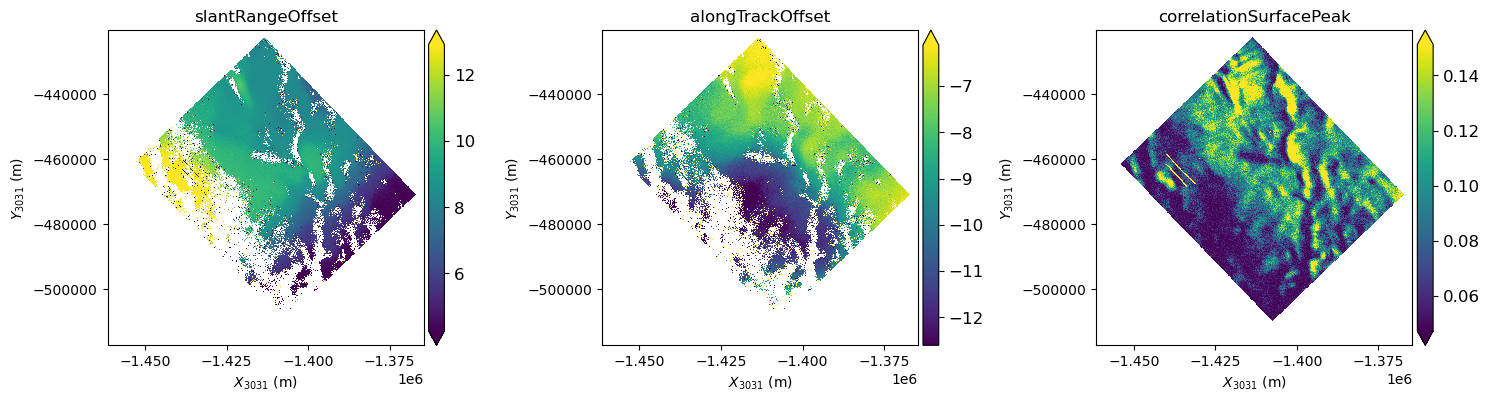

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
fields = ['slantRangeOffset', 'alongTrackOffset', 'correlationSurfacePeak']
layer = 2
for field, ax, cbE in zip(fields, axes, cbarExtend):
    # Extract the data for each field
    data = np.squeeze(getattr(myGOFF, field)[layer-1])
    # threshold at top and bottom 5%
    vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='none', extent=myGOFF.extentUL)
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend=cbE)
    ax.set_title(field)
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel(f'$X_{{{myGOFF.epsg}}}$ (m)')
    ax.set_ylabel(f'$Y_{{{myGOFF.epsg}}}$ (m)')
fig.tight_layout()
fig.tight_layout()

### Undo Changes

The chamges made above can be undone with `myGOFF.refresh()` as shown below.

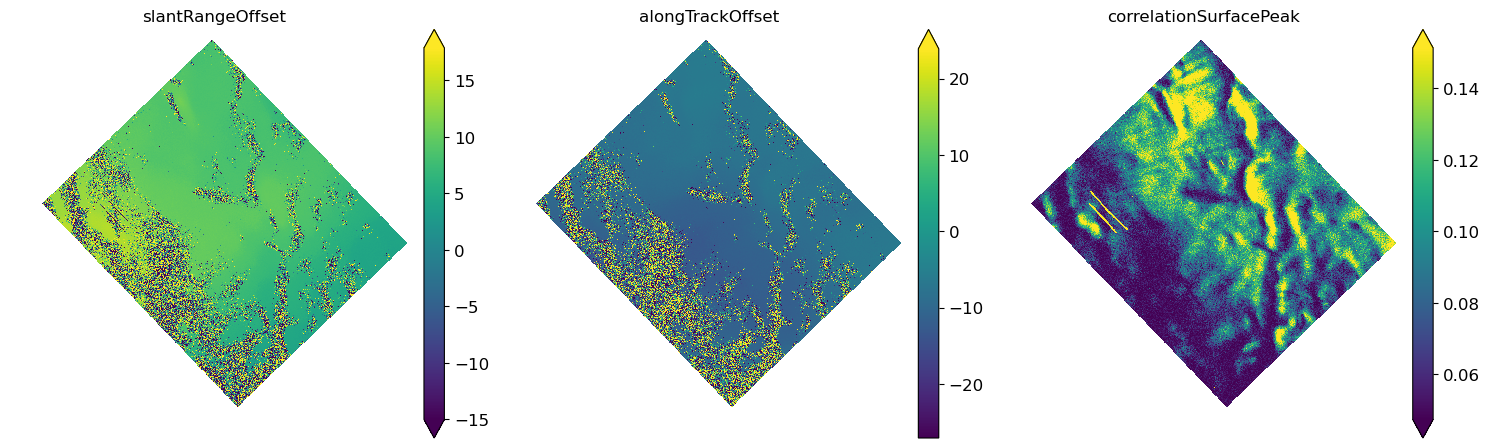

In [12]:
myGOFF.refresh()
#
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
fields = ['slantRangeOffset', 'alongTrackOffset', 'correlationSurfacePeak']
layer = 2
for field, ax, cbE in zip(fields, axes, cbarExtend):
    # Extract the data for each field
    data = np.squeeze(getattr(myGOFF, field)[layer-1])
    # threshold at top and bottom 5%
    vmin, vmax = autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='none')
    colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend=cbE)
    ax.set_title(field)
    ax.axis('off')
fig.tight_layout()

## Metadata Interpolation

Much of the spatially dependent information (e.g., incidenceAngle) is stored at meta data cubes (see nisar documenation). These cubes can be interpolatated to obtain the x, alongTrack, and elevation dependent results. Here are examples of how to extract these data for the offset grids.

In each case, an interpolator is setup. Once the setup has occurred, you can interpolated `myGOFF.interpolatorCubeName([[z, yTime, x]])`. Interpolating to a grid can be acomplished by `myGOFF.interpGrid(myGOFF.interpolatorCubeName, zGrid, yGrid, xGrid)`.

**Note for speed when they are not needed, most of the interpolators and grids need to be explicitly initialized before use as shown below**

### Setup Grid for the Offsets

In this step a range/Dopper grid corresponding to the offset maps is created. Note in this example we assume zero elevation. The current est products do not include the elevation for each point, but in the future the elevations in R/D coordinates will be available.

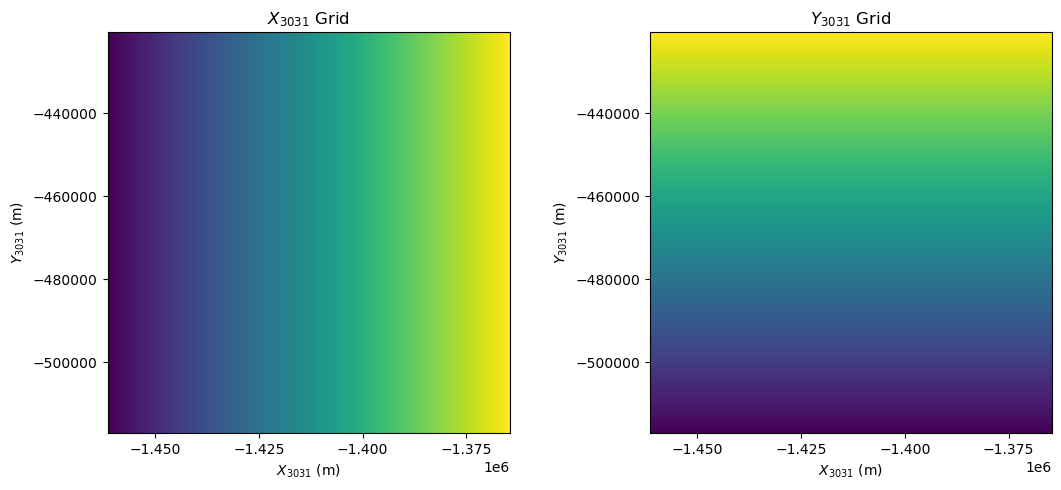

In [13]:
myGOFF.setupXYGrid()
z = np.zeros(myGOFF.xGrid.shape)
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes[0].imshow(myGOFF.xGrid, extent=myGOFF.extentUL)
axes[1].imshow(myGOFF.yGrid, extent=myGOFF.extentUL)
for ax, field in zip(axes, [f'$X_{{{myGOFF.epsg}}}$ Grid',f'$Y_{{{myGOFF.epsg}}}$ Grid']):
    ax.set_title(field)
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel(f'$X_{{{myGOFF.epsg}}}$ (m)')
    ax.set_ylabel(f'$Y_{{{myGOFF.epsg}}}$ (m)')
fig.tight_layout()

### Incidence and Elevation Angles

The incidence and elevation angles can be computed as follows:

incidenceAngle min/max: 38.101 41.605
elevationAngle min/max: 34.010 37.005


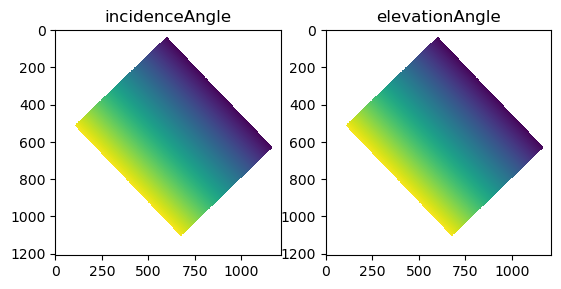

In [14]:
incidenceAngle = myGOFF.incidenceAngleCube(myGOFF.xGrid, myGOFF.yGrid, z, maskNoData=myGOFF.noDataLocations)
elevationAngle = myGOFF.elevationAngleCube(myGOFF.xGrid, myGOFF.yGrid, z, maskNoData=myGOFF.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [incidenceAngle, elevationAngle], ['incidenceAngle', 'elevationAngle']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Ground Track Velocity

The ground track velocty is found by:

groundTrackVelocity min/max: 6859.956 6864.671


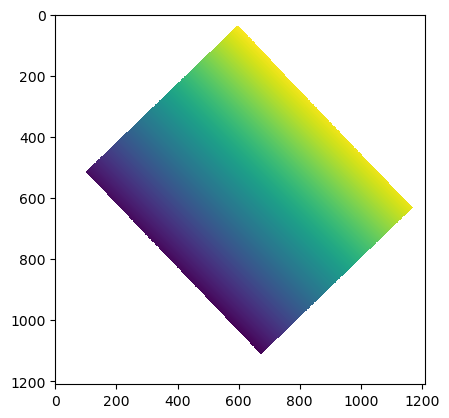

In [15]:
groundTrackVelocity=  myGOFF.groundTrackVelocityCube(myGOFF.xGrid, myGOFF.yGrid, z, maskNoData=myGOFF.noDataLocations)
fig, ax = plt.subplots(1,1)
ax.imshow(groundTrackVelocity)
print(f'groundTrackVelocity min/max: {np.nanmin(groundTrackVelocity):.3f} {np.nanmax(groundTrackVelocity):.3f}')

### Range-Doppler Coordinate

The `slantRange` and `zeroDopplerTime` coordinate at corresponding to the `x` and `y` can can be determined as:

slantRange min/max: 815981.418 852453.392
zeroDopplerTime min/max: 53867.278 53877.051


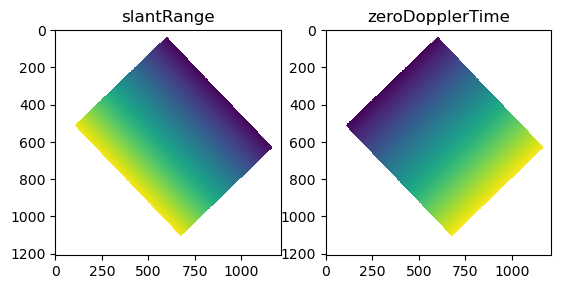

In [16]:
slantRange, zeroDopplerTime =  myGOFF.rangeDopplerCube(myGOFF.xGrid, myGOFF.yGrid, z, image='reference', maskNoData=myGOFF.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [slantRange, zeroDopplerTime], ['slantRange', 'zeroDopplerTime']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

## Baseline Components

The perpendicular and parallel baseline components are computed as follows:

bn min/max: 91.381 96.576
bp min/max: 74.616 76.304


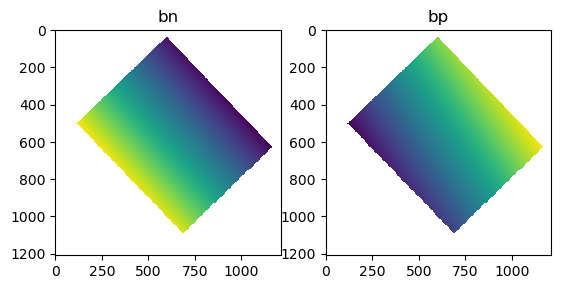

In [17]:
bn, bp =  myGOFF.baselineCube(myGOFF.xGrid, myGOFF.yGrid, z, maskNoData=myGOFF.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [bn, bp], ['bn', 'bp']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Along Track Unit Vector and LOS Unit Vector

The x and y components of the line-of-sight and along-track unit vector can be determined on the offset grid by:

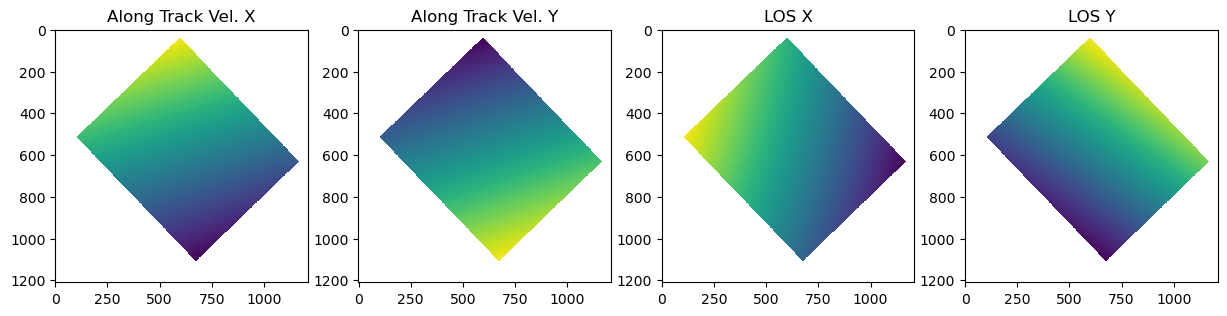

In [18]:
ATx, ATy =  myGOFF.alongTrackUnitVectorCube(myGOFF.xGrid, myGOFF.yGrid, z, maskNoData=myGOFF.noDataLocations)
LOSx, LOSy=  myGOFF.losUnitVectorCube(myGOFF.xGrid, myGOFF.yGrid, z, maskNoData=myGOFF.noDataLocations)
#
fig, axes = plt.subplots(1, 4, figsize=(15,5))
for ax, var, title in zip(axes.flatten(), [ATx, ATy, LOSx, LOSy], ['Along Track Vel. X', 'Along Track Vel. Y', 'LOS X', 'LOS Y']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)

## Other Meta Data

Most of the essential meta data has been parsed and demonstrated in the examples above. Other quantities can be extracted by keyword from the h5 files. For example, the **centerFrequency** can be extracted as:

In [19]:
np.array(myGOFF.h5['GOFF']['grids']['frequencyA']['centerFrequency']).item()

1257500238.0418074

## Save Data to Binary or Tiff Files.

The data from the hdf can be save as individual tiffs, bound together by a single vrt file. The default is to write all of the bands e.,g `'slantRangeOffset', 'slantRangeOffsetVariance', 'alongTrackOffset', 'crossOffsetVariance', `correlationSurfacePeak`, and `snr` for a **GOFF** product, which is accomplished as follows.

In [20]:
myGOFF.writeData('output/GOFFbinary', bands=['slantRangeOffset', 'alongTrackOffset', 'correlationSurfacePeak'], tiff=False)

In the previous example, the results were save as tiffs. To save as tiff files, run with `tiff=True`.

The data can be read back in as an `rioxarray`  using `nisarhdf.readVrtAsXarray`, which saves each band as a named data variable. The results can be displayed using the `xarray` version of `imshow`.

<xarray.Dataset>
Dimensions:                 (x: 1211, y: 1210)
Coordinates:
  * x                       (x) float64 -1.461e+06 -1.461e+06 ... -1.365e+06
  * y                       (y) float64 -4.204e+05 -4.204e+05 ... -5.171e+05
    spatial_ref             int64 0
Data variables:
    slantRangeOffset        (y, x) float32 nan nan nan nan ... nan nan nan nan
    alongTrackOffset        (y, x) float32 ...
    correlationSurfacePeak  (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/22)
    bands:                    ['slantRangeOffset', 'alongTrackOffset', 'corre...
    ByteOrder:                LSB
    datetime:                 2023-08-04 14:57:47.166045
    dx:                       80.0
    dy:                       -80.0
    epsg:                     3031
    ...                       ...
    SLCFirstZeroDopplerTime:  53867.166045
    SLCLastZeroDopplerTime:   53877.165933569675
    SLCNearRange:             814637.0
    Wavelength:               0.23840349999999996
    xSize:                    1211
    ySize:                    1210

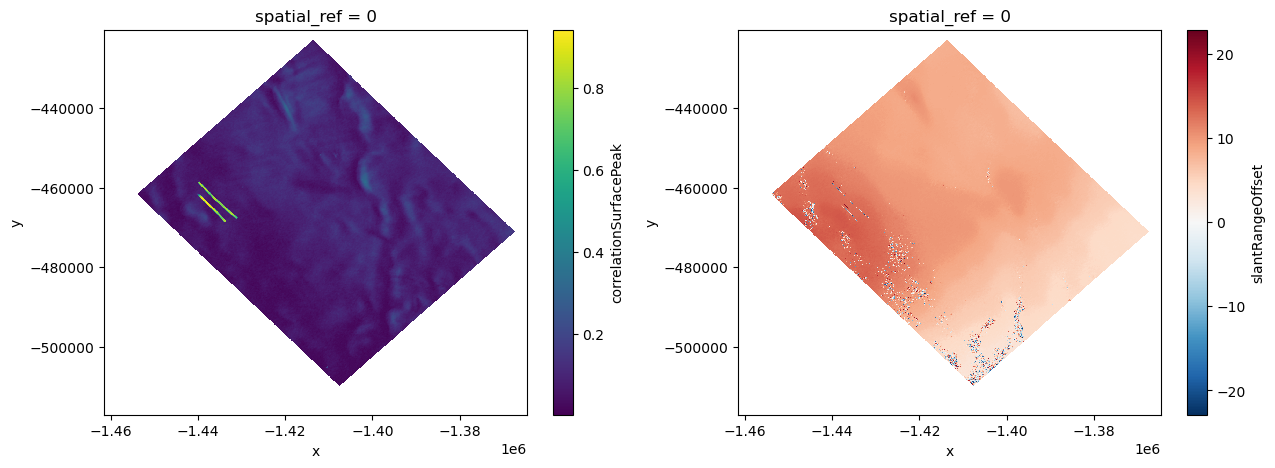

In [21]:
GOFFbinary = nisarhdf.readVrtAsXarray('output/GOFFbinary.layer3.vrt', mask_and_scale=True)
#extent = [np.min(GOFFbinary.x), np.max(GOFFbinary.x), np.min(GOFFbinary.y), np.max(GOFFbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
GOFFbinary.correlationSurfacePeak.plot.imshow(ax=axes[0])
GOFFbinary.slantRangeOffset.plot.imshow(ax=axes[1], cmap='RdBu_r')
GOFFbinary

## Save Gridded Data Cubes

The gridded data cubes can also be saved as either flat binary or as cloud-optimized geotiff (COG) files. In this case, use `save=True` to save the result internally, and then use `writeData` to save data the same way the other bands are saved. In the example below, the data are saved as COGs.

In [22]:
myGOFF.incidenceAngleCube(myGOFF.xGrid, myGOFF.yGrid, z, maskNoData=myGOFF.noDataLocations, save=True);
myGOFF.elevationAngleCube(myGOFF.xGrid, myGOFF.yGrid, z, maskNoData=myGOFF.noDataLocations, save=True);
myGOFF.writeData('output/GOFFangles',bands=['incidenceAngle', 'elevationAngle'], tiff=True) # ', 'elevationAngle'

<xarray.Dataset>
Dimensions:         (x: 1211, y: 1210)
Coordinates:
  * x               (x) float64 -1.461e+06 -1.461e+06 ... -1.365e+06 -1.365e+06
  * y               (y) float64 -4.204e+05 -4.204e+05 ... -5.17e+05 -5.171e+05
    spatial_ref     int64 0
Data variables:
    incidenceAngle  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    elevationAngle  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/22)
    bands:                    ['incidenceAngle', 'elevationAngle']
    ByteOrder:                LSB
    datetime:                 2023-08-04 14:57:47.166045
    dx:                       80.0
    dy:                       -80.0
    epsg:                     3031
    ...                       ...
    SLCFirstZeroDopplerTime:  53867.166045
    SLCLastZeroDopplerTime:   53877.165933569675
    SLCNearRange:             814637.0
    Wavelength:               0.23840349999999996
    xSize:                    1211
    ySize:                    1210

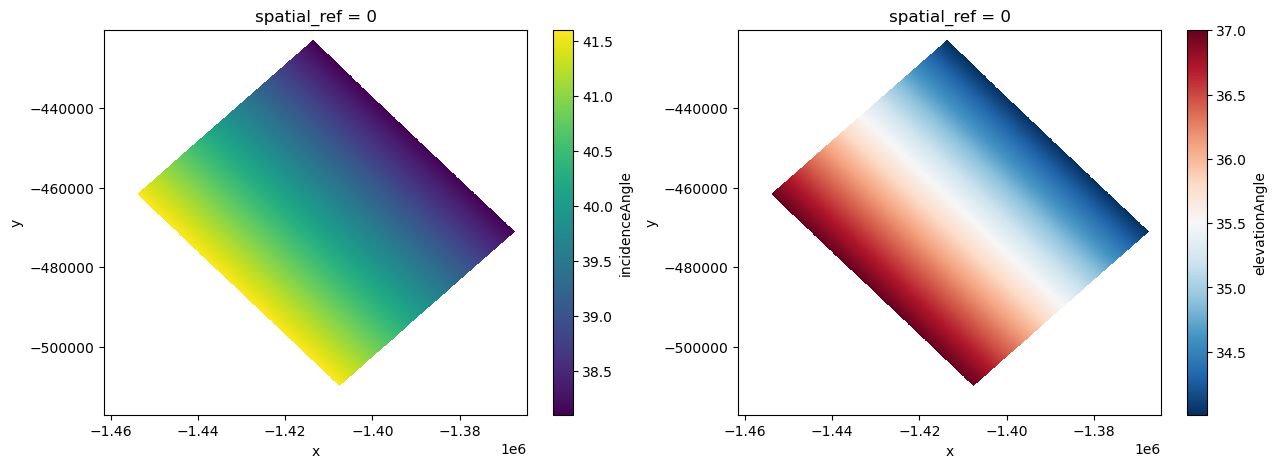

In [23]:
GOFFTiff = nisarhdf.readVrtAsXarray('output/GOFFangles.vrt', mask_and_scale=True)
#extent = [np.min(GOFFbinary.x), np.max(GOFFbinary.x), np.min(GOFFbinary.y), np.max(GOFFbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
GOFFTiff.incidenceAngle.plot.imshow(ax=axes[0])
GOFFTiff.elevationAngle.plot.imshow(ax=axes[1], cmap='RdBu_r')
GOFFTiff

# Anything below here is debug code that can be ignored